# Animal Shelter (Random Forest)


In [61]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [62]:
df = pd.read_csv("train.csv")

In [63]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [64]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


Also load the intake dataset downloaded from https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm so as to augment the kaggle dataset with further information about the animals.

# 1. Data Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [65]:
def splitSex(df):
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)
    df[["SexuponOutcome", "Sex", "Neutered"]].head()
    
splitSex(df)

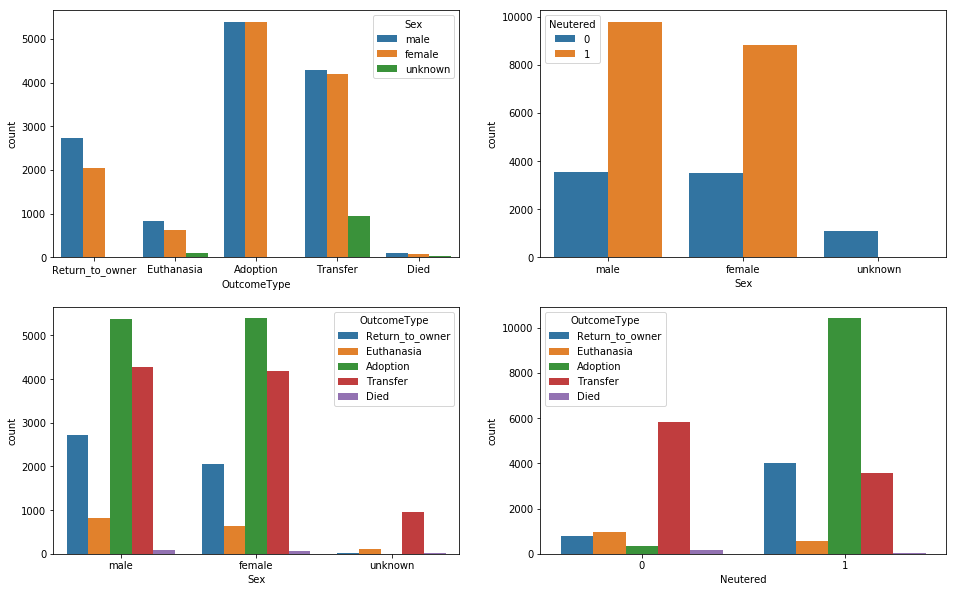

In [66]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up breed

In [67]:
def cleanupBreed(df):
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

Plot normalized ratios of outcomes by breed purity. Purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

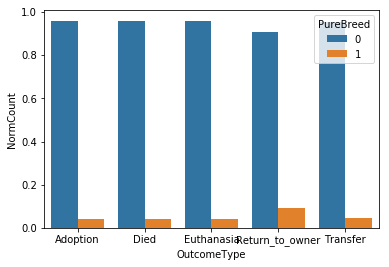

In [68]:
def normalizeCounts(df, x, sub_x, norm_over_x=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if norm_over_x:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not norm_over_x:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed", norm_over_x=True), x="OutcomeType", hue="PureBreed", y="NormCount")
#sns.countplot(data=df, x="OutcomeType", hue="PureBreed")

The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [69]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

def preprocessBreed(df):
    vec = CountVectorizer()
    
    breedsTDM = vec.fit_transform(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.shape
    
    return breedsTDM
    
def processBreed(df, breedsTDM):
    breedsdf = pd.DataFrame(breedsTDM.toarray())
    breedCols = ["Breed_"+str(i) for i in range(0, breedsTDM.shape[1]) ]
    breedsdf.columns = breedCols
    #print breedsdf.head()

    df = df.join(breedsdf)
    #print df.head()
    return df

breedsTDM = preprocessBreed(df)
df = processBreed(df, breedsTDM)
df.head()

(26729, 261)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_251,Breed_252,Breed_253,Breed_254,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,0,0,0,0,0,0,0,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,0,0,0,0,0,0,0,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,0,0,0,0,0,0,0,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0,0,0,0,0,0,0,0,0,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0,0,0,0,0,0,0,0,0,0


We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [70]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
processAge(df)


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

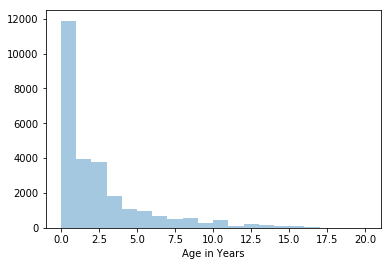

In [71]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that juveniles are more likely to be adopted (or transferred) than any other age bracket. Babies are less likely to be adopted as shelters usually don't allow them to until they are weaned and are also the most likely to die. Interestingly senior dogs are more likely to be returned to their owner. These facts should have explanatory value in our model.

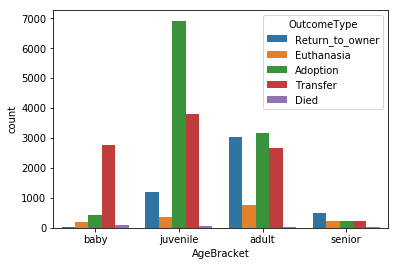

In [72]:


sns.countplot(data=df, x="AgeBracket", hue="OutcomeType", order=["baby", "juvenile", "adult", "senior"])

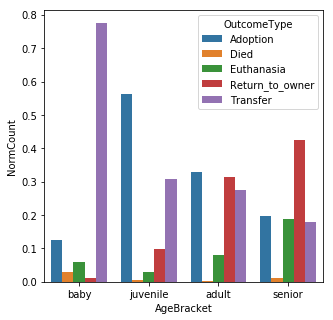

In [73]:
# Generate distribution of dog sizes grouped by outcome, normalized over outcome.
f, ax1 = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType", norm_over_x=True), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "juvenile", "adult", "senior"])



Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 15:00.

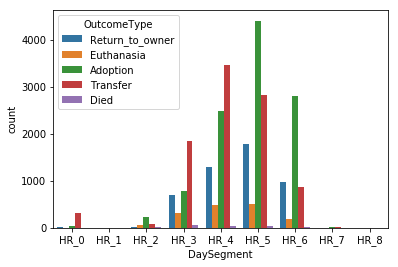

In [74]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
    df["OutcomeHour"] = df["DateTime"].dt.hour
    
processDate(df)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

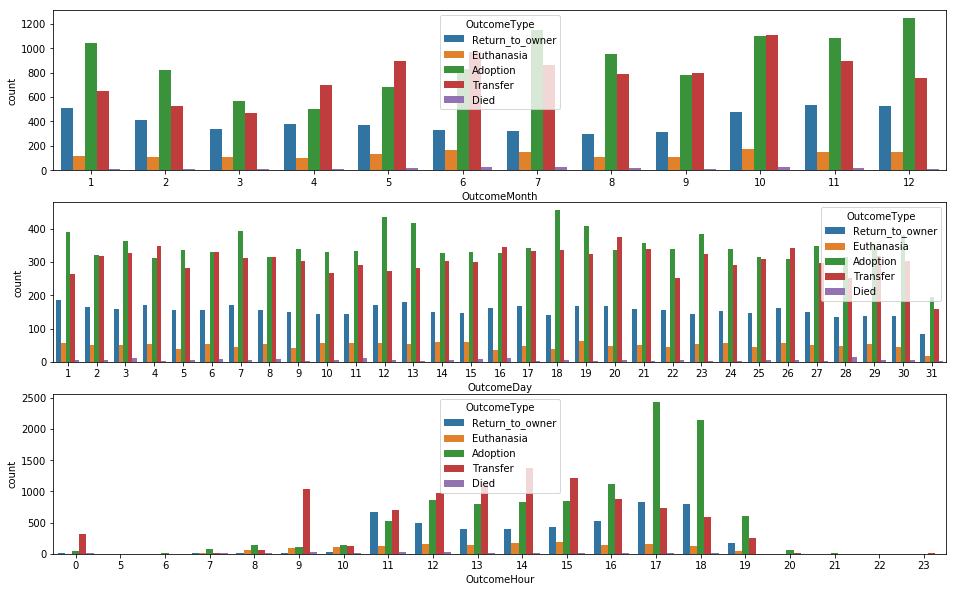

In [75]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
sns.countplot(data=df, x="OutcomeMonth", hue="OutcomeType", ax=ax1)
sns.countplot(data=df, x="OutcomeDay", hue="OutcomeType", ax=ax2)
sns.countplot(data=df, x="OutcomeHour", hue="OutcomeType", ax=ax3)
plt.show()

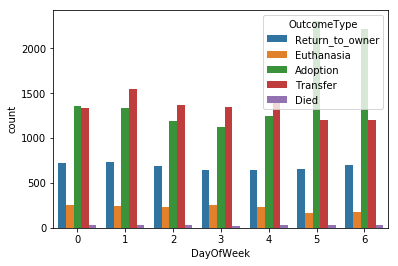

In [76]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

In order to capture this information we create a new "IsWeekend" field in our dataset.

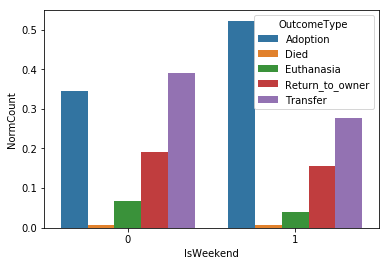

In [77]:
def processWeekend(df):
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)
#sns.countplot(data=df, x="IsWeekend", hue="OutcomeType")


processWeekend(df)
sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", norm_over_x=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

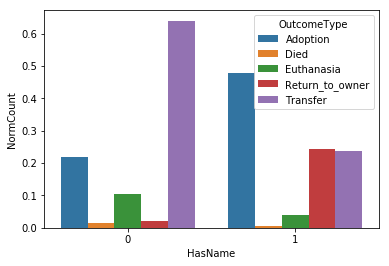

In [78]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

#sns.countplot(data=df, x="HasName", hue="OutcomeType")
sns.barplot(data=normalizeCounts(df, "HasName", "OutcomeType", norm_over_x=True), x="HasName", hue="OutcomeType", y="NormCount")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [79]:
df["Color"].unique().size

366

In [80]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


processColor(df)

print df["SimpleColor"].unique().size
df[["Color", "SimpleColor"]].head()


29


,Color,SimpleColor
0,Brown/White,brown
1,Cream Tabby,cream
2,Blue/White,blue
3,Blue Cream,blue
4,Tan,tan


['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


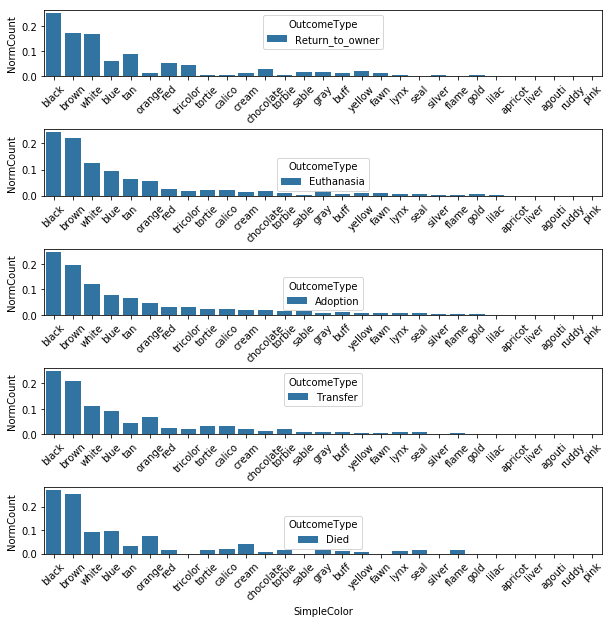

In [81]:
outcomes = df["OutcomeType"].unique()
print outcomes
f, ax1 = plt.subplots(outcomes.size, 1, figsize=(10, 10))

df["SimpleColor"].value_counts().index
for i in range(0,len(outcomes)):
    outcome = outcomes[i]
    ax1[i].tick_params(axis="x", rotation=45)
    sns.barplot(data=normalizeCounts(df.loc[df["OutcomeType"]==outcome,:], x="SimpleColor", sub_x="OutcomeType", norm_over_x=False), x="SimpleColor", hue="OutcomeType", y="NormCount", order=df["SimpleColor"].value_counts().index, ax=ax1[i])
    
f.subplots_adjust(hspace=0.8)

How balanced or unbalanced are our classes?

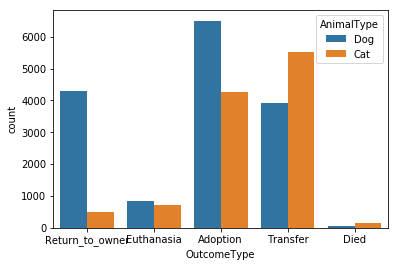

In [82]:
sns.countplot(data=df, x="OutcomeType", hue="AnimalType")

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [83]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [84]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_260,AgeDays,AgeBracket,DaySegment,OutcomeDay,OutcomeMonth,OutcomeHour,IsWeekend,HasName,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,365.0,juvenile,HR_6,12,2,18,0,1,brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,365.0,juvenile,HR_4,13,10,12,1,1,cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,730.0,adult,HR_4,31,1,12,1,1,blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0,21.0,baby,HR_6,11,7,19,0,0,blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0,730.0,adult,HR_4,15,11,12,0,0,tan


Select only the fields we need for learning.

In [85]:
# Experimentally reduce problem to a binary lives/dies classification
def reduceOutcome(outcome):
    return outcome in ("Adoption", "Return_to_owner", "Transfer")

# reduce outcome classes to lives/dies
def prepareOutcome(df):
    df["OutcomeTypeReduced"]=prepared_df["OutcomeType"].apply(reduceOutcome)
    
#prepareOutcome(df)

print df.head()
prepared_df = df.copy()
prepared_df = prepared_df.drop(["AnimalID", "Name", "DateTime", "OutcomeSubtype", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_df.head()


  AnimalID     Name            DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone 2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily 2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce 2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN 2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN 2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color     ...      Breed_260  AgeDays  AgeBracket  DaySegment  \
0  Brown/White     ...  

Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [86]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
    #('OutcomeType', None), #preprocessing.LabelEncoder()),
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     #("Size", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None),
#     ("Intake Type", preprocessing.LabelBinarizer()),
#     ("Intake Condition", preprocessing.LabelBinarizer())
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder())
], df_out=True)



In [87]:

classes_array = labelMapper.fit_transform(prepared_df)

prepared_fitted_df = mapper.fit_transform(prepared_df)

# Drop redundant columns to avoid the Dummy Variable Trap
prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)

# Create features array for learning
features_array = prepared_fitted_df.values 

print prepared_fitted_df.columns
    
print classes_array.head()

prepared_fitted_df.head()
#prepared_fitted_df.to_csv("temp.csv")

Index([u'AnimalType', u'Sex_female', u'Sex_male', u'Neutered', u'PureBreed',
       u'AgeBracket_adult', u'AgeBracket_baby', u'AgeBracket_juvenile',
       u'DaySegment_HR_0', u'DaySegment_HR_1',
       ...
       u'Breed_255', u'Breed_256', u'Breed_257', u'Breed_258', u'Breed_259',
       u'Breed_260', u'AgeDays', u'OutcomeDay', u'OutcomeMonth',
       u'OutcomeHour'],
      dtype='object', length=282)
   OutcomeType
0            3
1            2
2            0
3            4
4            4


,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260,AgeDays,OutcomeDay,OutcomeMonth,OutcomeHour
0,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,365,12,2,18
1,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,365,13,10,12
2,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730,31,1,12
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,21,11,7,19
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730,15,11,12


In [88]:
for c in prepared_fitted_df.columns.values:
    print c

AnimalType
Sex_female
Sex_male
Neutered
PureBreed
AgeBracket_adult
AgeBracket_baby
AgeBracket_juvenile
DaySegment_HR_0
DaySegment_HR_1
DaySegment_HR_2
DaySegment_HR_3
DaySegment_HR_4
DaySegment_HR_5
DaySegment_HR_6
IsWeekend
HasName
Breed_0
Breed_1
Breed_2
Breed_3
Breed_4
Breed_5
Breed_6
Breed_7
Breed_8
Breed_9
Breed_10
Breed_11
Breed_12
Breed_13
Breed_14
Breed_15
Breed_16
Breed_17
Breed_18
Breed_19
Breed_20
Breed_21
Breed_22
Breed_23
Breed_24
Breed_25
Breed_26
Breed_27
Breed_28
Breed_29
Breed_30
Breed_31
Breed_32
Breed_33
Breed_34
Breed_35
Breed_36
Breed_37
Breed_38
Breed_39
Breed_40
Breed_41
Breed_42
Breed_43
Breed_44
Breed_45
Breed_46
Breed_47
Breed_48
Breed_49
Breed_50
Breed_51
Breed_52
Breed_53
Breed_54
Breed_55
Breed_56
Breed_57
Breed_58
Breed_59
Breed_60
Breed_61
Breed_62
Breed_63
Breed_64
Breed_65
Breed_66
Breed_67
Breed_68
Breed_69
Breed_70
Breed_71
Breed_72
Breed_73
Breed_74
Breed_75
Breed_76
Breed_77
Breed_78
Breed_79
Breed_80
Breed_81
Breed_82
Breed_83
Breed_84
Breed_85
Bre

Supersample the data using the SMOTE algorithm so as to mitigate the problem of class imbalance.

In [89]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

#sm = SMOTE(random_state=42, kind="borderline2", n_jobs=4)
#ss_features, ss_classes = sm.fit_sample(features_array, classes_array)
ss_features = features_array
ss_classes = classes_array.values

binarizer = preprocessing.LabelBinarizer()
#ss_classes = binarizer.fit_transform(ss_classes)
X_train, X_test, y_train, y_test = train_test_split(features_array, classes_array.values.ravel(), test_size=0.3, random_state=42)

#sm = SMOTE(random_state=42, kind="borderline2", n_jobs=4)
#X_train, y_train = sm.fit_sample(X_train, y_train)

print features_array.shape
print classes_array.shape
print X_train.shape
print y_train.shape


(26729, 282)
(26729, 1)
(18710, 282)
(18710,)


In [38]:
import xgboost as xgb
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

n_iter = 10
k_fold = 3
  
cv = StratifiedKFold(y_train,n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
param_grid = {'max_depth': sp_randint(1, 90),
              'learning_rate': sp_uniform(loc=0e0,scale=1e0),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': [0.01,0.017782794,0.031622777,0.056234133,\
                            0.1,0.17782794,0.31622777,0.56234133,1.,1.77827941,\
                            3.16227766,5.62341325,10.,\
                            17.7827941,31.6227766,56.2341325,100.],
              'colsample_bytree': sp_uniform(loc=0.2e0,scale=0.8e0),
              'subsample': sp_uniform(loc=0.2e0,scale=0.8e0),
              'n_estimators': sp_randint(50, 200)}
  
search_GB = RandomizedSearchCV(GB,param_grid,scoring='neg_log_loss', n_iter=n_iter,cv=cv,verbose=10, n_jobs=2).fit(X_train,y_train)
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.823795997145, missing=nan, learning_rate=0.0226988826597, n_estimators=97, subsample=0.408378336847, objective=multi:softprob, max_depth=84 
[CV] reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.823795997145, missing=nan, learning_rate=0.0226988826597, n_estimators=97, subsample=0.408378336847, objective=multi:softprob, max_depth=84 
[CV]  reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.823795997145, missing=nan, learning_rate=0.0226988826597, n_estimators=97, subsample=0.408378336847, objective=multi:softprob, max_depth=84, score=-0.894063 - 3.4min


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  3.4min


[CV] reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.823795997145, missing=nan, learning_rate=0.0226988826597, n_estimators=97, subsample=0.408378336847, objective=multi:softprob, max_depth=84 
[CV]  reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.823795997145, missing=nan, learning_rate=0.0226988826597, n_estimators=97, subsample=0.408378336847, objective=multi:softprob, max_depth=84, score=-0.886893 - 3.3min
[CV] reg_alpha=1.77827941, n_jobs=2, colsample_bytree=0.552693874746, missing=nan, learning_rate=0.691420169132, n_estimators=107, subsample=0.766047470471, objective=multi:softprob, max_depth=27 
[CV]  reg_alpha=1.77827941, n_jobs=2, colsample_bytree=0.552693874746, missing=nan, learning_rate=0.691420169132, n_estimators=107, subsample=0.766047470471, objective=multi:softprob, max_depth=27, score=-0.908329 - 2.8min
[CV] reg_alpha=1.77827941, n_jobs=2, colsample_bytree=0.552693874746, missing=nan, learning_rate=0.691420169132, n_estimators=107, subsample=0.766047470471, obj

[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  6.9min


[CV] reg_alpha=1.77827941, n_jobs=2, colsample_bytree=0.552693874746, missing=nan, learning_rate=0.691420169132, n_estimators=107, subsample=0.766047470471, objective=multi:softprob, max_depth=27 
[CV]  reg_alpha=1.77827941, n_jobs=2, colsample_bytree=0.552693874746, missing=nan, learning_rate=0.691420169132, n_estimators=107, subsample=0.766047470471, objective=multi:softprob, max_depth=27, score=-0.893153 - 2.9min
[CV] reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.512451505337, missing=nan, learning_rate=0.294679682872, n_estimators=146, subsample=0.847210620525, objective=multi:softprob, max_depth=37 
[CV]  reg_alpha=1.77827941, n_jobs=2, colsample_bytree=0.552693874746, missing=nan, learning_rate=0.691420169132, n_estimators=107, subsample=0.766047470471, objective=multi:softprob, max_depth=27, score=-0.910539 - 2.8min
[CV] reg_alpha=0.17782794, n_jobs=2, colsample_bytree=0.512451505337, missing=nan, learning_rate=0.294679682872, n_estimators=146, subsample=0.847210620525, obj

[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 18.2min


[CV] reg_alpha=17.7827941, n_jobs=2, colsample_bytree=0.988054007902, missing=nan, learning_rate=0.320984973536, n_estimators=144, subsample=0.805192123495, objective=multi:softprob, max_depth=30 
[CV]  reg_alpha=17.7827941, n_jobs=2, colsample_bytree=0.988054007902, missing=nan, learning_rate=0.320984973536, n_estimators=144, subsample=0.805192123495, objective=multi:softprob, max_depth=30, score=-0.803157 - 5.3min
[CV] reg_alpha=17.7827941, n_jobs=2, colsample_bytree=0.988054007902, missing=nan, learning_rate=0.320984973536, n_estimators=144, subsample=0.805192123495, objective=multi:softprob, max_depth=30 
[CV]  reg_alpha=17.7827941, n_jobs=2, colsample_bytree=0.988054007902, missing=nan, learning_rate=0.320984973536, n_estimators=144, subsample=0.805192123495, objective=multi:softprob, max_depth=30, score=-0.789713 - 5.6min
[CV] reg_alpha=10.0, n_jobs=2, colsample_bytree=0.385094237002, missing=nan, learning_rate=0.960010443231, n_estimators=189, subsample=0.579377620273, objective

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 28.8min


[CV] reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.852057547754, missing=nan, learning_rate=0.979515179087, n_estimators=134, subsample=0.898143106899, objective=multi:softprob, max_depth=47 
[CV]  reg_alpha=10.0, n_jobs=2, colsample_bytree=0.385094237002, missing=nan, learning_rate=0.960010443231, n_estimators=189, subsample=0.579377620273, objective=multi:softprob, max_depth=55, score=-0.820133 - 3.2min
[CV] reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.852057547754, missing=nan, learning_rate=0.979515179087, n_estimators=134, subsample=0.898143106899, objective=multi:softprob, max_depth=47 
[CV]  reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.852057547754, missing=nan, learning_rate=0.979515179087, n_estimators=134, subsample=0.898143106899, objective=multi:softprob, max_depth=47, score=-0.815204 - 2.6min
[CV] reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.852057547754, missing=nan, learning_rate=0.979515179087, n_estimators=134, subsample=0.898143106899, objective

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 39.2min


[CV] reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.725580307947, missing=nan, learning_rate=0.595300760149, n_estimators=150, subsample=0.436492412717, objective=multi:softprob, max_depth=16 
[CV]  reg_alpha=0.031622777, n_jobs=2, colsample_bytree=0.295984877993, missing=nan, learning_rate=0.0991242461266, n_estimators=149, subsample=0.905998904882, objective=multi:softprob, max_depth=82, score=-0.832366 - 3.2min
[CV] reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.725580307947, missing=nan, learning_rate=0.595300760149, n_estimators=150, subsample=0.436492412717, objective=multi:softprob, max_depth=16 
[CV]  reg_alpha=31.6227766, n_jobs=2, colsample_bytree=0.725580307947, missing=nan, learning_rate=0.595300760149, n_estimators=150, subsample=0.436492412717, objective=multi:softprob, max_depth=16, score=-0.807512 - 1.7min
[CV] reg_alpha=0.031622777, n_jobs=2, colsample_bytree=0.81398112683, missing=nan, learning_rate=0.916676400145, n_estimators=72, subsample=0.262120751687, ob

[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 46.2min finished


  -0.797278956307
  {'reg_alpha': 5.62341325, 'n_jobs': 2, 'colsample_bytree': 0.52605500347528933, 'missing': nan, 'learning_rate': 0.064258457713594841, 'n_estimators': 140, 'subsample': 0.98851834712965414, 'objective': 'multi:softprob', 'max_depth': 8}


In [90]:
from numpy import nan
#params={'reg_alpha': 31.6227766, 'n_jobs': 2, 'colsample_bytree': 0.92004019236052659, 'missing': nan, 'learning_rate': 0.45372879619918061, 'n_estimators': 172, 'subsample': 0.4933391563450169, 'objective': 'multi:softprob', 'max_depth': 43}
params={'reg_alpha': 5.62341325, 'n_jobs': 2, 'colsample_bytree': 0.52605500347528933, 'missing': nan, 'learning_rate': 0.064258457713594841, 'n_estimators': 140, 'subsample': 0.98851834712965414, 'objective': 'multi:softprob', 'max_depth': 8}
GB = xgb.XGBClassifier(**params)

GB.fit(X_train, y_train)

preds = GB.predict(X_test)

proba = GB.predict_proba(X_test)

print preds
print proba


[3 0 4 ..., 4 4 3]
[[ 0.19143151  0.00367177  0.17447492  0.46863678  0.16178502]
 [ 0.82208776  0.00323112  0.00812646  0.01022908  0.15632561]
 [ 0.00918923  0.00839564  0.11858395  0.01059727  0.85323387]
 ..., 
 [ 0.08254141  0.00654887  0.00631458  0.01405465  0.89054048]
 [ 0.03714629  0.01283573  0.11207454  0.0209236   0.81701982]
 [ 0.21122056  0.00322     0.1113729   0.48082563  0.19336091]]


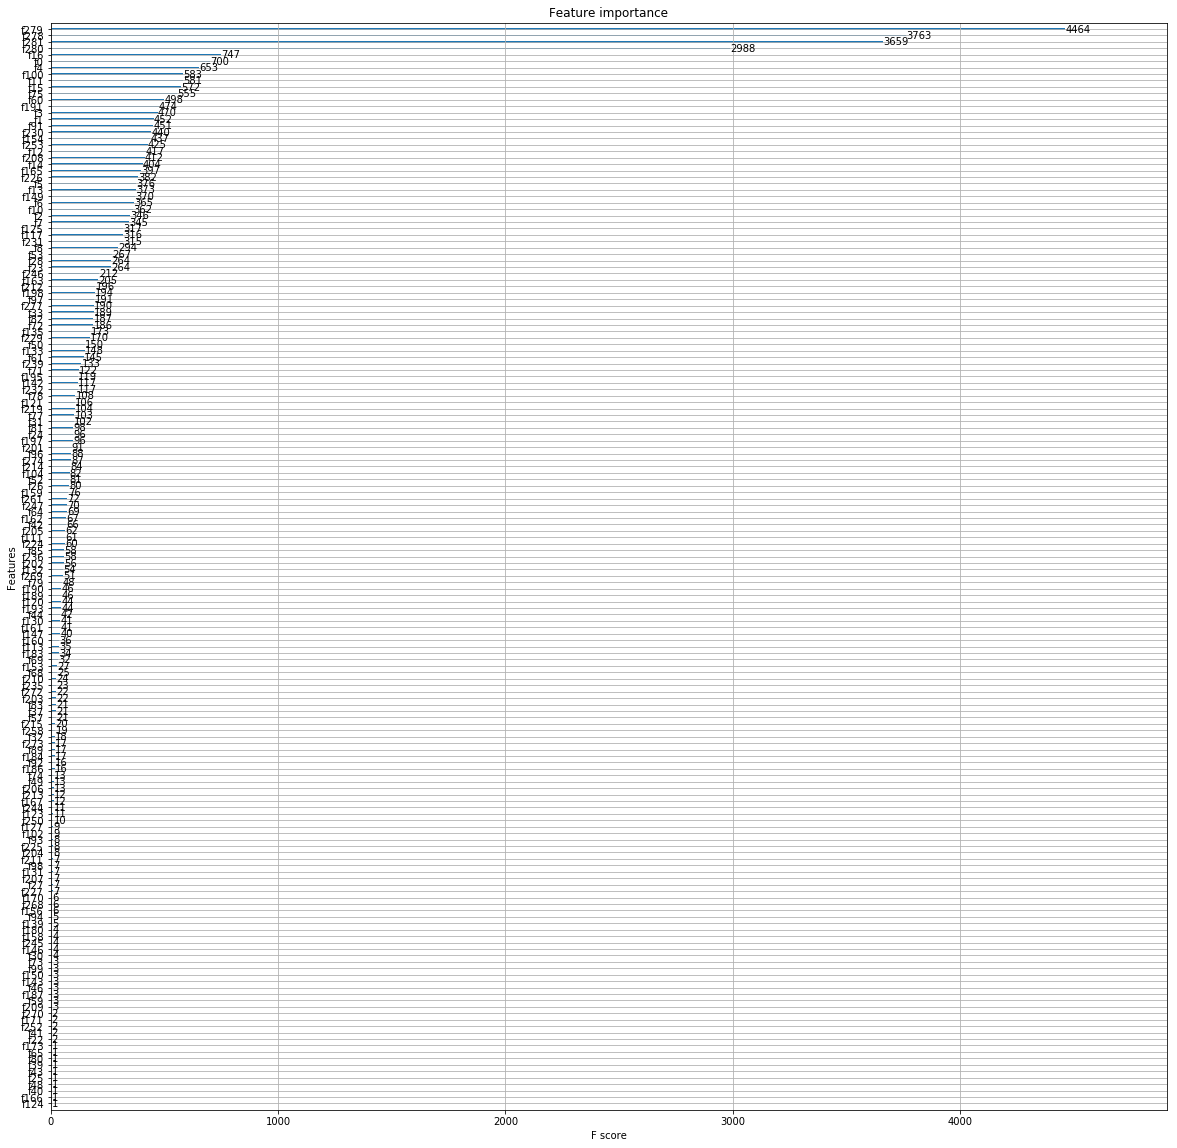

1.0
[[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ..., 
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]]
[[ 0.19143151  0.00367177  0.17447492  0.46863678  0.16178502]
 [ 0.82208776  0.00323112  0.00812646  0.01022908  0.15632561]
 [ 0.00918923  0.00839564  0.11858395  0.01059727  0.85323387]
 ..., 
 [ 0.08254141  0.00654887  0.00631458  0.01405465  0.89054048]
 [ 0.03714629  0.01283573  0.11207454  0.0209236   0.81701982]
 [ 0.21122056  0.00322     0.1113729   0.48082563  0.19336091]]


In [108]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#plt.bar(range(len(GB.feature_importances_)), GB.feature_importances_)
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(GB, ax=ax)
plt.show()
print np.sum(GB.feature_importances_)


y_test_bin = label_binarize(y_test, GB.classes_)
print y_test_bin
print proba
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(GB.n_classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

f1 score= 0.670130585464
log loss= 0.756513834199


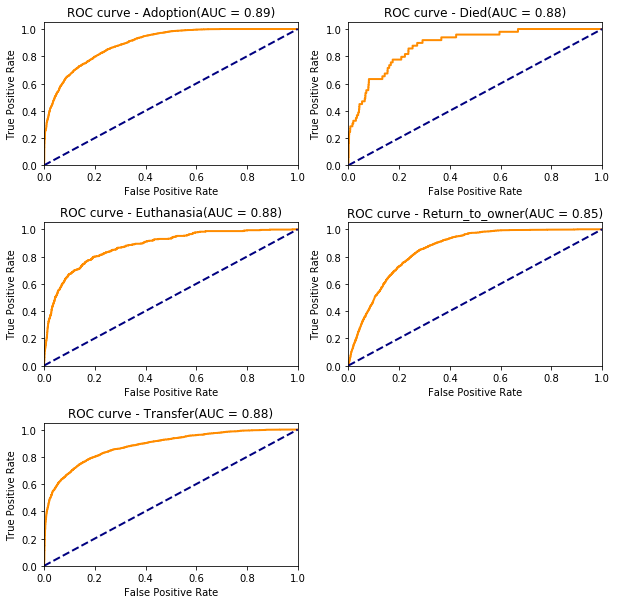

In [92]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

print "f1 score=", f1_score(y_test, preds, average="weighted")
print "log loss=", log_loss(y_test, proba, labels=GB.classes_)

f, plts = plt.subplots(3, 2, figsize=(10, 10))

plts = plts.ravel()
lw = 2

classlabels=labelMapper.features[0][1].inverse_transform(GB.classes_)

for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
    #plt.subplot(3,2,cls+1)
    if (cls < GB.n_classes_):
        plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
        plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plts[cls].set_xlim([0.0, 1.0])
        plts[cls].set_ylim([0.0, 1.05])
        plts[cls].set_xlabel('False Positive Rate')
        plts[cls].set_ylabel('True Positive Rate')
        plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
        plt.legend(loc="lower right")
    else:
        plts[cls].axis("off")

f.subplots_adjust(hspace=0.4)
plt.show()

In [93]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test, preds)
print np.sum(preds==0)
print np.sum(y_test==0)
print sum(cm[:,0])
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
3889
3259
3889


array([[2726,    0,    1,  299,  233],
       [   5,    3,    5,    2,   34],
       [  66,    2,   76,   99,  209],
       [ 579,    0,    6,  660,  198],
       [ 513,    2,   41,  234, 2026]])

In [42]:

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

clf2 = RandomForestClassifier(n_jobs=4, n_estimators=50, bootstrap=False)


cvobj = StratifiedKFold(n_splits=3, shuffle=True)
#selector = RFECV(svm.SVC(kernel="linear"), cv=3)
selector = RFECV(clf2, cv=cvobj, scoring="f1_weighted")
selector.fit(X_train, np.ravel(y_train))
print selector.support_
print selector.ranking_
print selector.grid_scores_

print max(selector.grid_scores_)
print min(selector.grid_scores_)
print avg(selector.grid_scores_)
#X_train_fitted2 = X_train2#[:,selector.support_]

#scores = cross_val_score(clf2, X_train, y_train, cv=cvobj, scoring="f1_weighted")
#print scores
#print np.average(scores)


[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False  True  True  True  True False  True  True  True False  True  True
  True  True False False False  True False False False False  True  True
  True False False False False False  True False  True  True False False
 False False False  True  True  True False False  True  True False False
  True  True False  True  True False False  True False  True  True  True
  True  True  True  True False  True False False False  True False  True
  True  True False False  True  True  True False  True False False False
  True False False False False False False  True False  True False False
 False  True False False  True  True False  True False  True False  True
 False  True  True  True  True  True False  True False False False False
 False False  True False False False False  True Fa

NameError: name 'avg' is not defined

In [43]:
print max(selector.grid_scores_)
print min(selector.grid_scores_)
print np.average(selector.grid_scores_)


0.787495349545
0.464885519022
0.778357562867


Which features did the Recursive Feature Elimination algorithm deem not important?

In [44]:
prepared_fitted_df.columns[selector.support_]

Index([u'AnimalType', u'Sex_female', u'Sex_male', u'Neutered', u'PureBreed',
       u'AgeBracket_adult', u'AgeBracket_baby', u'AgeBracket_juvenile',
       u'DaySegment_HR_0', u'DaySegment_HR_2',
       ...
       u'Breed_241', u'Breed_244', u'Breed_251', u'Breed_252', u'Breed_253',
       u'Breed_254', u'Breed_255', u'Breed_257', u'Breed_260', u'AgeDays'],
      dtype='object', length=159)

In [45]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

clf2.fit(X_train[:,selector.support_], y_train)
proba = clf2.predict_proba(X_test[:,selector.support_])
preds = clf2.predict(X_test[:,selector.support_])
print preds
print X_test.shape
print y_test.shape
print "f1 score=", f1_score(y_test, preds, average="weighted")
print "log loss=", log_loss(y_test, proba, labels=clf2.classes_)
comp = (preds==y_test)
print proba
print comp
print y_test
print preds
print (float(sum(comp)))/len(comp)



[3 0 4 ..., 4 4 4]
(8019, 295)
(8019,)
f1 score= 0.638564816307
log loss= 1.273052964
[[ 0.26  0.    0.28  0.34  0.12]
 [ 0.78  0.    0.02  0.    0.2 ]
 [ 0.04  0.    0.16  0.    0.8 ]
 ..., 
 [ 0.08  0.    0.    0.    0.92]
 [ 0.26  0.    0.14  0.    0.6 ]
 [ 0.08  0.    0.12  0.06  0.74]]
[False False  True ...,  True  True False]
[0 4 4 ..., 4 4 3]
[3 0 4 ..., 4 4 4]
0.648584611548


In [52]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, clf2.classes_)
print y_test_bin
print proba
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(clf2.n_classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

[[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ..., 
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]]
[[  1.19817279e-01   1.72175374e-03   4.61744845e-01   3.37324053e-01
    7.93920681e-02]
 [  8.47383559e-01   1.18445209e-03   8.19705799e-03   8.85764882e-03
    1.34377286e-01]
 [  1.67025020e-03   1.07976736e-03   7.73991570e-02   1.63170439e-03
    9.18219090e-01]
 ..., 
 [  1.21685807e-02   8.72565550e-04   1.77686263e-04   4.86582378e-03
    9.81915355e-01]
 [  1.54857952e-02   3.50386067e-03   7.24546835e-02   1.29161635e-02
    8.95639479e-01]
 [  2.37568602e-01   1.35883165e-03   3.71843874e-01   2.84099072e-01
    1.05129652e-01]]


NameError: name 'clf2' is not defined

In [ ]:
f, plts = plt.subplots(3, 2, figsize=(10, 10))

plts = plts.ravel()
lw = 2

classlabels=labelMapper.features[0][1].inverse_transform(clf2.classes_)

for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
    #plt.subplot(3,2,cls+1)
    if (cls < clf2.n_classes_):
        plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
        plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plts[cls].set_xlim([0.0, 1.0])
        plts[cls].set_ylim([0.0, 1.05])
        plts[cls].set_xlabel('False Positive Rate')
        plts[cls].set_ylabel('True Positive Rate')
        plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
        plt.legend(loc="lower right")
    else:
        plts[cls].axis("off")

f.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
testdf = pd.read_csv("test.csv")

splitSex(testdf)
cleanupBreed(testdf)
testdf = processBreed(testdf, breedsTDM)    
processAge(testdf)    
processDate(testdf)
processWeekend(testdf)
processName(testdf)
processColor(testdf)
#prepareOutcome(testdf)

prepared_testdf = testdf.copy()
print prepared_testdf.head()
prepared_testdf = prepared_testdf.drop(["ID", "Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)
#prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)

print prepared_testdf.head()

prepared_fitted_testdf = mapper.fit_transform(prepared_testdf)

#prepared_fitted_df = prepared_fitted_df.drop(["SimpleColor"], axis=1)
##prepared_fitted_df["Size"] = preprocessing.StandardScaler().fit_transform(prepared_fitted_df[["Size"]])
#prepared_fitted_df["SimpleColor"] = preprocessing.StandardScaler(prepared_fitted_df["SimpleColor"])
print prepared_fitted_testdf.columns
# Drop redundant columns to avoid the Dummy Variable Trap
#if animal=="Dog":
prepared_fitted_testdf = prepared_fitted_testdf.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor" ], axis=1)
prepared_fitted_testdf.head()

In [ ]:
#clf2.fit(ss_features[:,selector.support_], ss_classes)

X_kaggle_test = prepared_fitted_testdf.values
print prepared_fitted_testdf.head()
print prepared_fitted_df.head()
preds = clf2.predict(X_kaggle_test[:,selector.support_])
probs = clf2.predict_proba(X_kaggle_test[:,selector.support_])
print clf2.classes_
print labelMapper.features[0][1].inverse_transform(clf2.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf